In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import time
import os

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem3 import ContrastiveExplanationMethod

In [2]:
dataset = MNIST(batch_size=64)
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN(device="cpu")

train_cnn(cnn, dataset, iterations=20, lr=0.01, save_fn='mnist-cnn', device="cpu", load_path="models/saved_models/mnist-cnn.h5")

In [4]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\david\Coding\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


In [5]:
# # evaluate the cnn by uncommenting this cell

# total_acc = 0
# total_batches = 0
# for step, (batch_inputs, batch_targets) in enumerate(dataset.test_loader):
    
#     predictions = cnn(batch_inputs)
#     acc = (predictions.argmax(1).cpu().numpy() == batch_targets.cpu().numpy()).sum()/(predictions.shape[0] )
#     total_batches += 1
#     total_acc += acc
    
# print("acc: {}".format(total_acc / total_batches))

# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [6]:
# Train or load autoencoder
cae = CAE(device="cpu")

train_ae(cae, dataset, iterations=10, save_fn="mnist-cae", device="cpu", load_path="models/saved_models/mnist-cae-no-rs.h5")

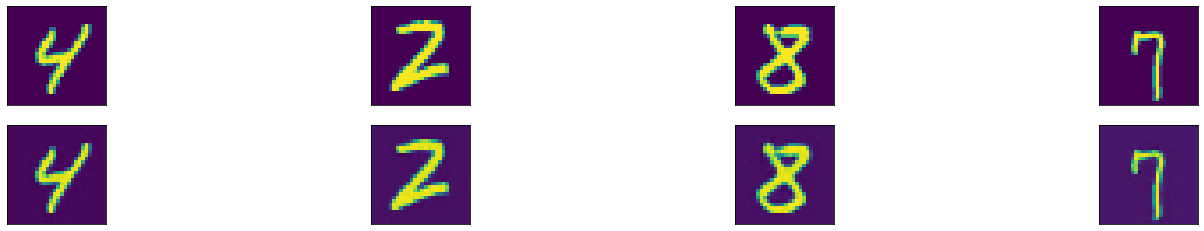

In [18]:
# obtain one batch of test images
images, _ = dataset.get_batch()

images += 0.5

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

# Contrastive Explanation Method

In [39]:
kappa = 10
gamma = 1.0
beta = 0.1
lr = 0.1
CEM = ContrastiveExplanationMethod(cnn, cae, iterations=1000, n_searches=9, kappa=kappa, gamma=gamma, beta=beta, learning_rate=lr)

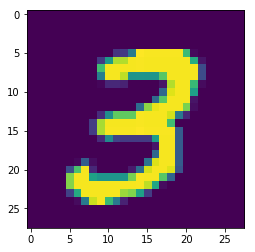

classified as: 3


In [40]:
# obtain one sample
image = dataset.get_sample_by_class(class_label=3, show_image=False)
#image, _ = dataset.get_sample(show_image=False)

plt.imshow(image.squeeze())
plt.show()
print("classified as: {}".format(np.argmax(cnn(image.view(-1,1,28,28)).detach())))

In [ ]:
# find pertinent negatives
mode = "PP"
CEM.fista(image, mode=mode)

new best: 178.803955078125
new best: 67.60099029541016
new best: 63.46223449707031
new best: 61.5415153503418
search: 0 iteration: 20 c: 10 loss: 85.74 found optimum: True
new best: 60.85737228393555
search: 0 iteration: 40 c: 10 loss: 234.69 found optimum: True
search: 0 iteration: 60 c: 10 loss: 73.40 found optimum: True
search: 0 iteration: 80 c: 10 loss: 77.20 found optimum: True
search: 0 iteration: 100 c: 10 loss: 97.04 found optimum: True
search: 0 iteration: 120 c: 10 loss: 197.11 found optimum: True
search: 0 iteration: 140 c: 10 loss: 362.47 found optimum: True
search: 0 iteration: 160 c: 10 loss: 110.40 found optimum: True
search: 0 iteration: 180 c: 10 loss: 92.63 found optimum: True
search: 0 iteration: 200 c: 10 loss: 92.17 found optimum: True
search: 0 iteration: 220 c: 10 loss: 104.96 found optimum: True
search: 0 iteration: 240 c: 10 loss: 87.69 found optimum: True
new best: 56.591190338134766
search: 0 iteration: 260 c: 10 loss: 82.40 found optimum: True
search: 0 ite

search: 2 iteration: 400 c: 2.5749999999999997 loss: 65.05 found optimum: True
search: 2 iteration: 420 c: 2.5749999999999997 loss: 65.05 found optimum: True
search: 2 iteration: 440 c: 2.5749999999999997 loss: 65.07 found optimum: True
search: 2 iteration: 460 c: 2.5749999999999997 loss: 65.08 found optimum: True
search: 2 iteration: 480 c: 2.5749999999999997 loss: 65.06 found optimum: True
search: 2 iteration: 500 c: 2.5749999999999997 loss: 65.07 found optimum: True
search: 2 iteration: 520 c: 2.5749999999999997 loss: 65.08 found optimum: True
search: 2 iteration: 540 c: 2.5749999999999997 loss: 65.22 found optimum: True
search: 2 iteration: 560 c: 2.5749999999999997 loss: 65.19 found optimum: True
search: 2 iteration: 580 c: 2.5749999999999997 loss: 65.24 found optimum: True
search: 2 iteration: 600 c: 2.5749999999999997 loss: 65.27 found optimum: True
search: 2 iteration: 620 c: 2.5749999999999997 loss: 65.62 found optimum: True
search: 2 iteration: 640 c: 2.5749999999999997 loss:

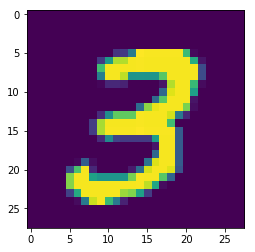

In [42]:
plt.imshow(image.squeeze())

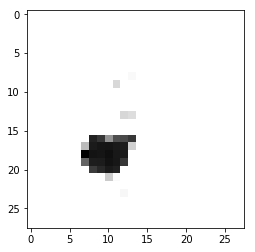

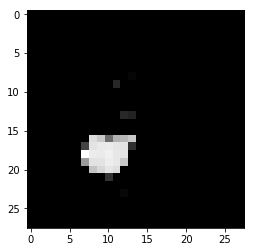

In [43]:
# perturbation
plt.imshow(image.squeeze()- CEM.best_delta.view(28,28), cmap="gray")
plt.show()
plt.imshow(CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
plt.show()

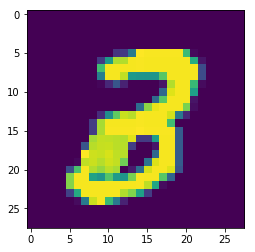

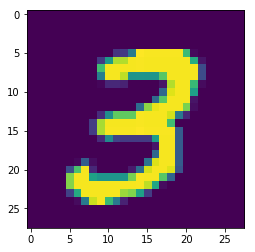

In [44]:
# original image with perturbation
plt.imshow(CEM.best_delta.view(28,28))
plt.show()

plt.imshow(image.view(28,28))
plt.show()

In [45]:
# print original image
plt.imshow(image.view(28,28), title="original image", cmap="gray")
plt.show()

# classification before
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
print("classification before perturbation: {}".format(before))

if mode == "PP":
    plt.imshow(CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
    plt.show()
    after = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
    print("classification of delta: {}".format(after))
else:
    plt.imshow(CEM.best_delta.view(28,28),  cmap="gray")
    plt.show()
    after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
    print("classification after perturbation: {}".format(after))

3

In [48]:
# save the created images
dirname = "saved_perturbations/mode-{}-kappa-{}-gamma-{}-beta-{}-lr-{}".format(mode, kappa, gamma, beta, lr)
os.makedirs(dirname, exist_ok=True)
fname_orig = dirname + "/{}-cb-{}-ca-{}-orig.png".format(int(time.time()), before, after)
fname_pert = dirname + "/{}-before-{}-after-{}-pert.png".format(int(time.time()), before, after)
fname_combined = dirname + "/{}-before-{}-after-{}-pn.png".format(int(time.time()), before, after)
fname_combined_pp = dirname + "/{}-before-{}-after-{}-pp.png".format(int(time.time()), before, after)
plt.imsave(fname_orig, image.squeeze(), cmap="gray")
plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
plt.imsave(fname_combined, CEM.best_delta.view(28,28), cmap="gray")
plt.imsave(fname_combined_pp, image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")